# Mapping targeted in-situ technologies to genome-scale espression maps

## Motivation 
Unlike spot-based spatial transcriptomics, targeted in-situ technologies (such as MERFISH, smFISH, or seqFISH+) are not limited in their spatial resolution but gene throughput, typically limited to a few hundreds of preselected genes. As a consequence, we face the orthogonal problem of increasing resolution with respect to genes instead of increasing spatial resolution and identifying cellular features. Hence, we would like to impute genes that are measured in scRNA-seq but not in FISH-based technologies.

## Constructing a map between technologies

A method that is widely applicable in the context of aligning spatial profiling measurements with common sc/snRNA-seq profiles is Tangram{cite}`biancalani_deep_2021`. An independent benchmark{cite}`li_benchmarking_2022` showed that Tangram outperformed other imputation methods like gimVI{cite}`DBLP:journals/corr/abs-1905-02269` and SpaGE{cite}`10.1093/nar/gkaa740` in terms of different accuracy metrics and scalability. While Tangram can also be applied in the previously described deconvolution context, we focus on its ability to map MERFISH data to whole genome expression profiles. The underlying idea of Tangram is the probabilistic alignment of two different technologies by means of a single shared modality, typically RNA-seq data. This way, limitation with respect to the number of genes that are measured or spatial resolution can be overcome. 

The mapping algorithm of Tangram builds on count matrices from the two technologies at hand. For sc/snRNa-seq data, this means to compute the matrix $S$ whose entry $S_{ik}$ indicates the expression level for cell $i$ and gene $k$: 
$$
S \in \mathbb{R}_+^{n_{\text{cells}}\times n_{\text{genes}}} \ \ \text{ with } \ \ S_{ik}>0 \quad . 
$$
The same procedure applies to spatial data. We build the matrix $G$ according to: 
$$
G \in \mathbb{R}_+^{n_{\text{voxels}}\times n_{\text{genes}}} \ \ \text{ with } \ \ G_{jk}>0
$$

For MERFISH data, a voxel means the aggregation of single gene measurements to individual cells while a voxels refers to the individual spots for Visium. Note that the specific order in the voxel dimension is arbitrary and that $n_genes$ corresponds to the shared subset of genes present in both technologies. 

<!-- I am not sure what the density for MERFISH would look like, all ones maybe? -->
Tangram makes further use of a voxel density vector $\textbf d$. This density corresponds to estimated cell densities which, for example, can be deduced from an image segmentation in the case of Visium data. Formally, we write: 

$$
\textbf{d} \in \mathbb{R}^{n_\text{voxels}} \ \ \text{ with } \ \ d_j \in [0,1]  \ \ \text{ and } \ \ \sum_j d_j = 1 \quad .
$$  

Given the matrices $S$ and $G$ as well as the density $\textbf d$, Tangram aims to learn a thrid matrix $M$ that expresses the probability $M_{ij} \in [0,1]$ that cell $i$ belongs to voxel $j$. Being probabilitistic, every cells has to be mapped exactly once, that is the rows of $M$ have to be normalised: 

$$
M \in \mathbb{R}^{n_{\text{cells}}\times n_{\text{voxels}}}_+ \ \ \text{ with } \ \ \sum_{j}^{n_\text{voxel}} M_{ij}=1 \quad . 
$$

Note that the sum across cells indicates the number of cells that are assigned to a voxel $j$. Knowing about the number of cells in $S$, we can estimate the voxel density as 
$$
m_j = \sum_{i}^{n_\text{cells}} \frac{M_{ij}}{n_\text{cells}} \quad . 
$$

Putting all parts together, we arrive at the objective function of Tangram: 
$$
L = \mathbb{KL}[\mathbf m, \mathbf d] - \sum_{k}^{n_\text{genes}} d_{\cos}(M^TS_{:k}, G_{:k}) - \sum_{j}^{n_\text{voxels}} d_{\cos}(M^TS_{j:}, G_{j:}) \quad , 
$$
where $M^TS$ is the predicted spatial gene expression, $\mathbb{KL}$ the Kullback-Leibler divergence and $d_{\cos}$ the cosine similarity. The first term matches the predicted voxel density $\textbf m$ with the estimated one $\textbf d$. The second term ensures that for each gene $k$ the predicted profile matches the expected profile from $G$. The third term serves the same purpose for each individual voxel: the predicted voxel expression should be close to the expected one from $G$. 

<!-- For MERFISH we have to use the filtered approach, maybe to cumbersome to introduce it? -->
In order to infer genome-scale expression maps for MERFISH data, we first identify the shared gene set which should result in about $\sim 200$ genes. Second, we compute the $S$ and $G$ matrices from the sc/scRNA-seq reference and the spatial assay, respectively. For MERFISH, the voxel density has uniform entries $1/n_{\text{voxels}}$ as the voxels correspond to cells themselve. Given this, we only have to optimise the obective $L$ and obtain the probabilistic mapping $M$. 

To infer the spatial expression for the whole genome $f_j$ for voxel $j$, one can either compute a weighted sum using the probabilistic cell assignments $f_j = \sum_i M_{ij} c_i$, where $c_i \in \mathbb{R}_+^{n'_\text{genes}}$ is the genome-wide expression profile from sc/snRNA-seq, or first compute a deterministic mapping via $i^*(j) = \argmax_i M_{ij}$ and then build the genome-scale profile as $f_j = c_{i^*(j)}$ . 

## Using Tangram in practise

:::{figure-md} imputation

<img src="../_static/images/spatial/imputation.jpeg" alt="Imputation Overview" class="bg-primary mb-1" width="800px">

Imputation methods leverage a whole transcriptome reference dataset to map cells onto space. Tangram learns a mapping matrix between the reference and the spatial dataset on the common gene set. 
:::

### Environment setup
Before we enter this notebook’s analysis, let’s set up our environment.

In [21]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import tangram as tg
import matplotlib.pyplot as plt
import seaborn as sns

sc.set_figure_params()

### Loading the data
The dataset used in this tutorial was measured by multiplexed error robust fluorescence in situ hybridization (MERFISH) and investigates the spatial organization and transcriptional profile of wild type hematopoietic stem cell (HSC) niches in fetal liver{cite}`lu_spatial_2021`. The dataset contains 140 images across four fetal livers at E14.5 with 132 genes observed in 40,864 cells. Lu et al.{cite}`lu_spatial_2021` additionally performed single-cell RNA sequencing of E14.5 whole fetal liver cells by 10x Genomics platform, which we will use as a whole transcriptome reference for this tutorial. 

We will first load the reference dataset.

In [2]:
# replace by simpler loading
path = '/lustre/groups/ml01/workspace/anna.schaar/ncem/data/lu/'

data_file = "GSM5242402_E14.5FL_matrix.mtx"
gene_file = "GSM5242402_E14.5FL_features.tsv"
barcode_file = "GSM5242402_E14.5FL_barcodes.tsv.gz"

adata_sc = sc.read(f"{path}GSE172129_RAW/{data_file}")
adata_sc = adata_sc.transpose()
adata_sc.X = adata_sc.X.toarray()

barcodes = pd.read_csv(f"{path}GSE172129_RAW/{barcode_file}", header=None, sep='\t')
genes = pd.read_csv(f"{path}GSE172129_RAW/{gene_file}", header=None, sep='\t')

barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata_sc.obs = barcodes

genes.rename(columns={0:'chozen_isoform', 1:'gene_short_name', 2:'code'}, inplace=True)
genes.set_index('gene_short_name', inplace=True)
adata_sc.var = genes

In [3]:
adata_sc

AnnData object with n_obs × n_vars = 9448 × 28692
    var: 'chozen_isoform', 'code'

The single-cell RNA-seq reference we are using to showcase the usage of Tangram is not annotated. We therefore apply a basic processing to obtain leiden clusters which we can later project onto the spatial dataset.

         Falling back to preprocessing with `sc.pp.pca` and default params.


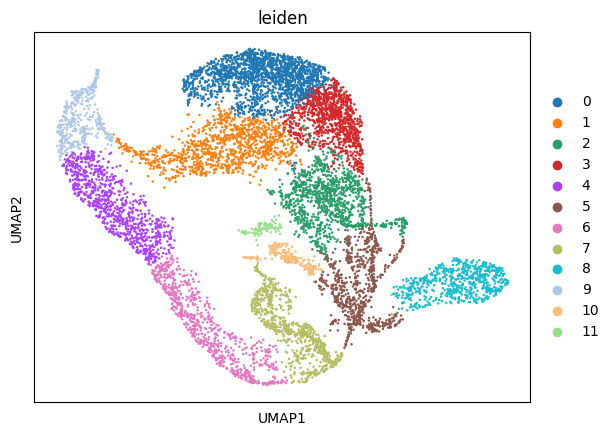

In [4]:
sc.pp.neighbors(adata_sc)
sc.tl.leiden(adata_sc, resolution=0.25)
sc.tl.umap(adata_sc)
sc.pl.umap(adata_sc, color='leiden')

Next, we load the spatial transcriptomics dataset. The MERFISH dataset contains data from X different field of views (FOV).

In [5]:
# replace by simpler loading (the data was only provided via Matlab code in the manuscript)
import anndata
df = pd.read_csv(f"{path}FinalClusteringResults 190517 WT.csv")
obs = df[["CellID", "FOV", "CellTypeID_new"]]
spatial = np.array(df[["Center_x", "Center_y"]])
X = df.iloc[:,1:-4]

adata_st = anndata.AnnData(
    X=X, obs=obs
)
adata_st.obsm['spatial'] = spatial

adata_st.obs["cell_type"] = list(
    pd.Series(list(adata_st.obs["CellTypeID_new"]), dtype="str").map(
        {
            "1": "AEC",
            "2": "SEC",
            "3": "MK",
            "4": "Hepatocyte",
            "5": "Macrophage",
            "6": "Myeloid",
            "7": "Erythroid progenitor",
            "8": "Erythroid cell",
            "9": "Unknown",
        }
    )
)

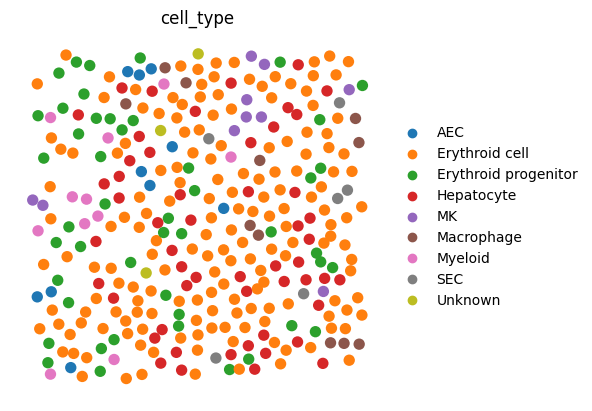

In [6]:
sc.pl.spatial(adata_st[adata_st.obs.FOV==0], color="cell_type", spot_size=50, frameon=False)

### Specifying training genes

We want to select our training genes. These genes are shared between the two datasets and should capture the biological variance between cell types. For this, we first compute marker genes on the single-cell data and then use Tangram's preprocessing function to subset to those genes that are also present in the spatial data.

In [7]:
markers = list(set.intersection(set(adata_sc.var_names), set(adata_st.var_names)))
len(markers)

132

`tg.pp_adatas` does the following: 
- Computes the overlap between single-cell data and spatial data on the list of genes provided in the `genes` argument
- Stores the resulting gene set under `'training_genes'` in both adata objects under the `.uns` key
- Enforces consitent ordering of the genes
- To reduce potential naming errors gene names are converted to lower case. To prevent this behaviour set ` gene_to_lowercase = False`.

In [8]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:132 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:132 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


Let us check that the function performs as we expect:

In [9]:
assert 'training_genes' in adata_sc.uns
assert 'training_genes' in adata_st.uns

print(f"Number of training_genes: {len(adata_sc.uns['training_genes'])}")

Number of training_genes: 132


### Computing the map from single-cells to spatial voxels

Having specified the training genes, we can now create the map from dissociated single-cell measurements to the spatial locations. For this, we are going to use the `maps_cells_to_space` function from tangram. This function has two different modes, `mode='cells'` and `mode='clusters'`. The latter only maps averaged single-cells which makes computationally faster and more robust when mapping between specimen. However, as we are interested in imputing our spatial data, we will rely on the cell mode which might require access to a GPU for reasonable runtime.

In [10]:
ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    mode="cells",                                       
    density_prior='rna_count_based',
    num_epochs=500,
    device='cuda', # or: cpu
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 132 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.271, KL reg: 0.346
Score: 0.911, KL reg: 0.005
Score: 0.931, KL reg: 0.002
Score: 0.938, KL reg: 0.002
Score: 0.941, KL reg: 0.001


INFO:root:Saving results..


The resulting `ad_map` is itself an adata object. Let us inspect it:

In [11]:
ad_map

AnnData object with n_obs × n_vars = 9448 × 40864
    obs: 'leiden'
    var: 'CellID', 'FOV', 'CellTypeID_new', 'cell_type', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

We observe that Tangram's mapping from cell i to spatial voxels j is stored in the `.X` property of `ad_map`

Hence, the meaning of the `.var` and `.obs` also changes: 
- in `.var` have the available metadata of the spatial data, `adata_st`
- in `.obs` have the available metadata of the single-cell data, `adata_sc`

In addition, the information about the training run is stored in the `.uns` key, see `.uns['training_genes_df']` and `.uns[training_history]`.

### Imputing genes and mapping cell-types to space

We can use this result in two ways. First, we can map the cell type information that was originally only present in the single-cell data to space. This an easy way to check that your results are biologically consistent by looking for known cell type patterns. Second, we can investigate the spatial gene-expression of those genes that have not been measured with the in-situ method in the first place, effectively imputing all the missing genes.

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


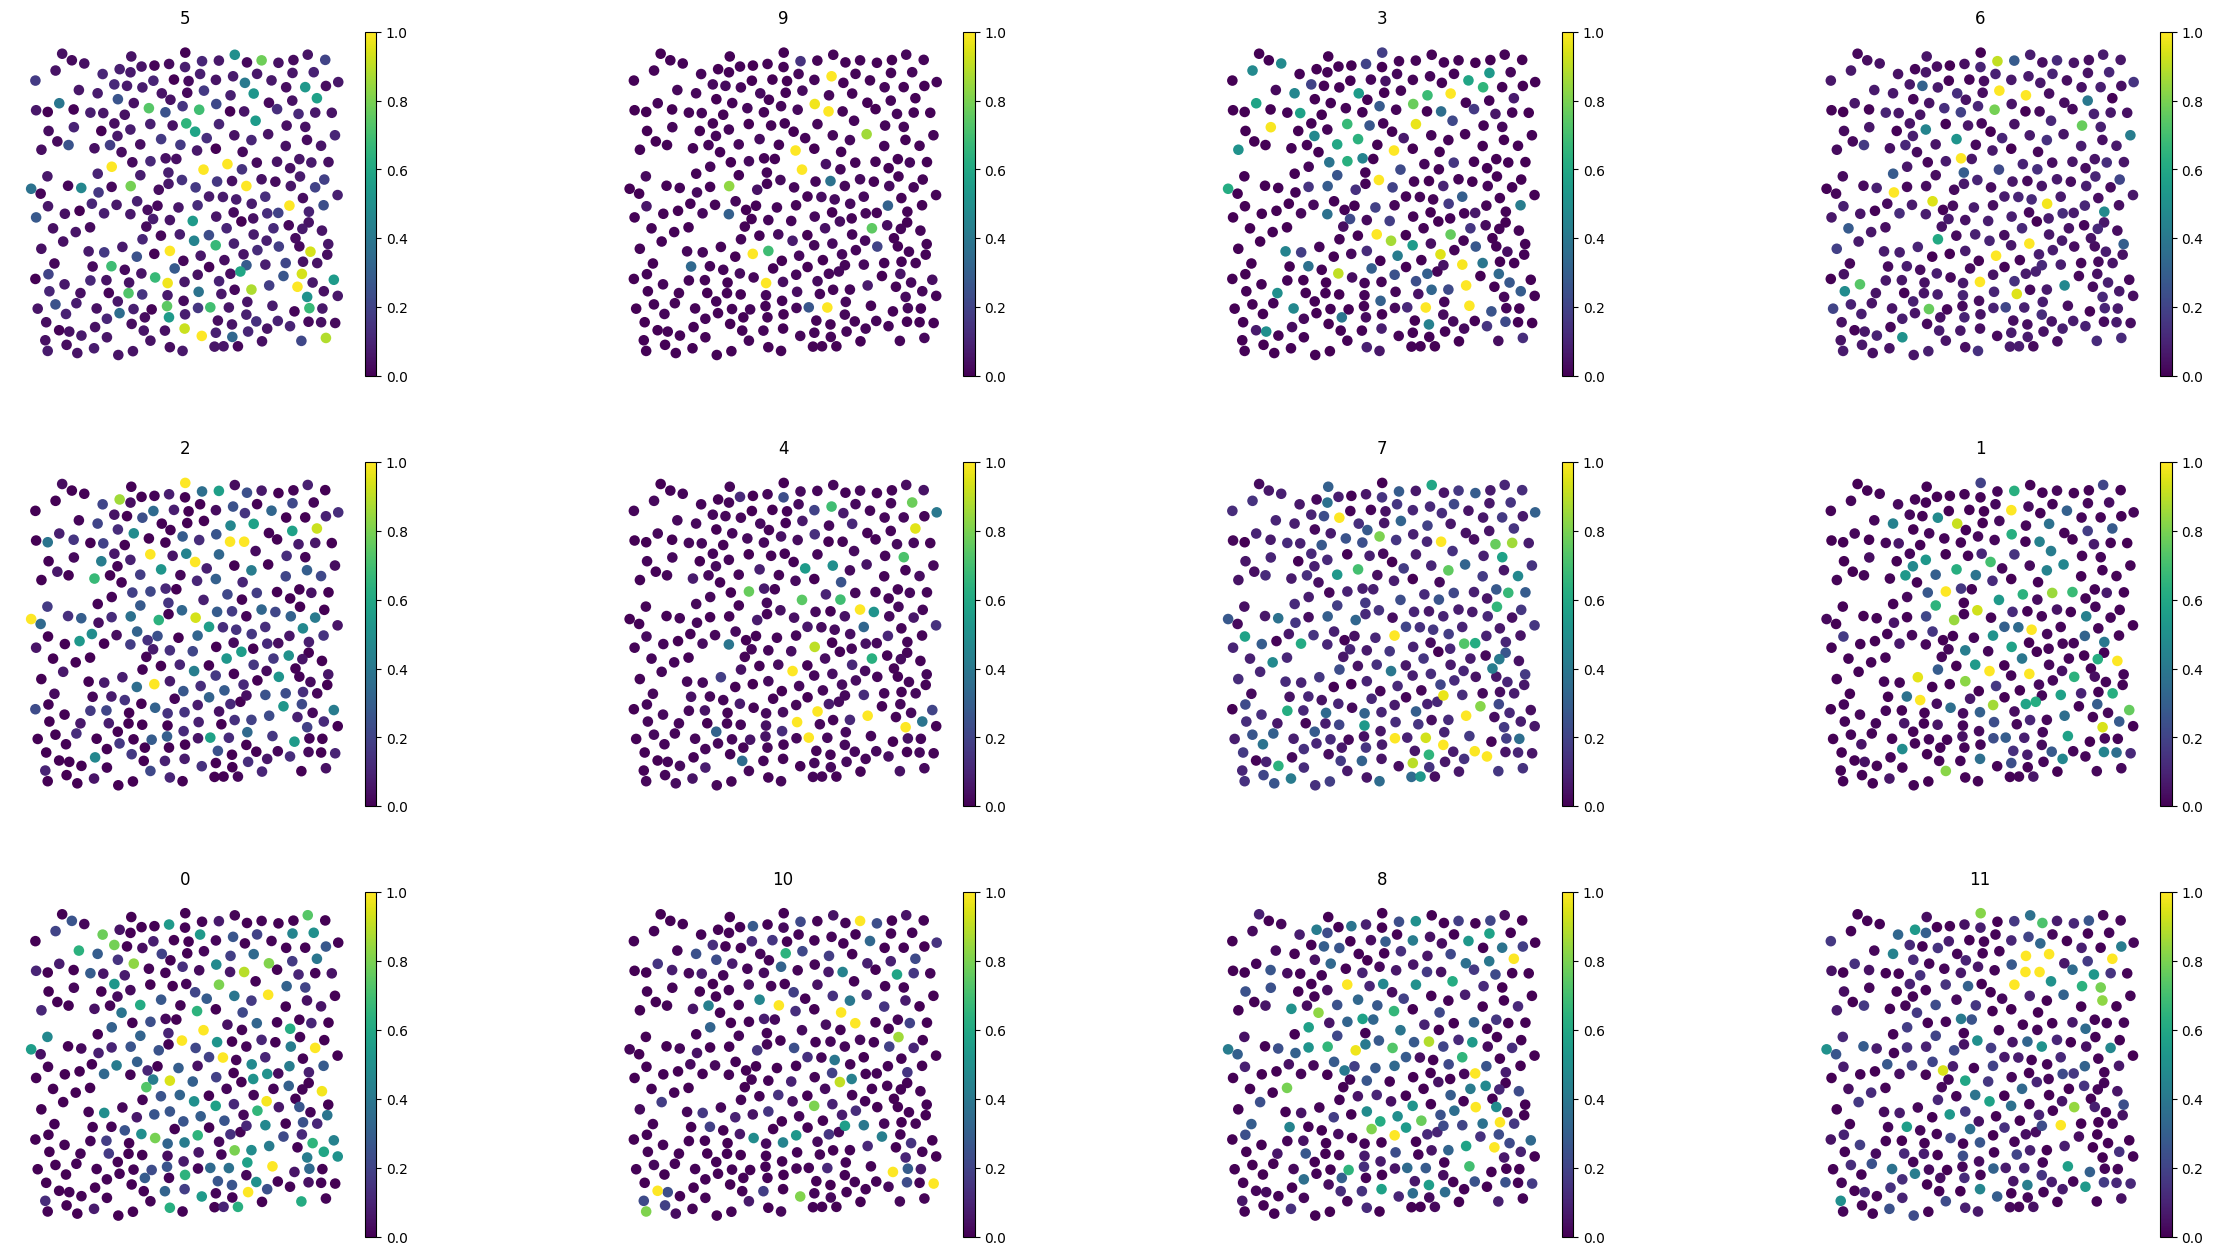

In [12]:
# Project the cell annotation to spatial locations
tg.project_cell_annotations(ad_map, adata_st, annotation="leiden")
annotation_list = list(pd.unique(adata_sc.obs['leiden']))

# Plot the spatial annotation
# The `perc` argument steers the range of the colourmap and can help with removing outliers.
tg.plot_cell_annotation_sc(adata_st[adata_st.obs.FOV==0], annotation_list,perc=0.02, spot_size=50)

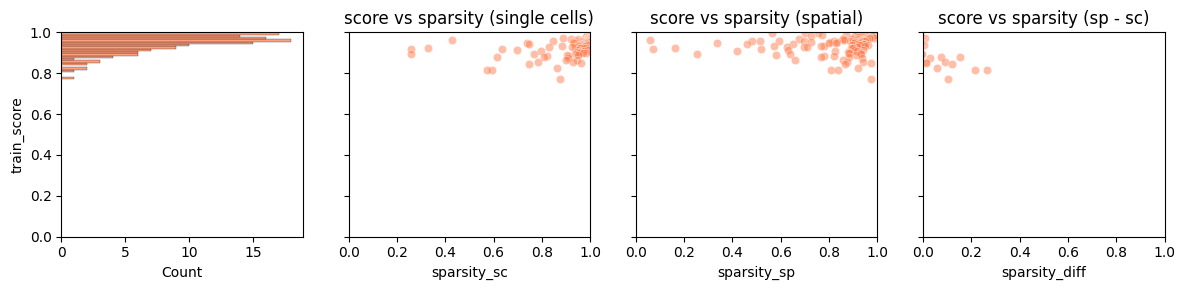

In [13]:
#  To get a deeper sense, Tangram also computes several scores, which are readily plotted
tg.plot_training_scores(ad_map, bins=20, alpha=.5)

The score generally measures the similarity between original measurement (by the spatial technology) and the inferred mapping by single-cell data. The middle panels both relate the sparsity of the respective data, single-cell and spatial, of a training genes (each dot is a training gene) with the achieved score. As you can see, the performance is much more correlated with the spatial data which is often more sparse and therefore responsible for low-quality mappings. The last panel sets both technologies in context. Genes that have similar sparsity levels in both spatial and single-cell data usually achieve better scores than those that are inconsistent across technologies. 

Minor remark: The similarity that Tangram builds on is cosine similarity.

Even more detailed information can be found in the `.uns["train_genes_df"]`.

To genes new spatial data, we can project the genes present in the single-cell data to the spatial locations. This is easily achieved by multiplying the mapping matrix stored in `ad_map` with the original single-cell data stored in `adata_sc`. Tangram already provides a convenience function which takes in a mapping and the corresponding single-cell data. The result is a spatial voxel by genes matrix which technically is identical to the original spatial data `adata_st` but contains expression values for all genes.

In [14]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)
ad_ge

AnnData object with n_obs × n_vars = 40864 × 17966
    obs: 'CellID', 'FOV', 'CellTypeID_new', 'cell_type', 'uniform_density', 'rna_count_based_density'
    var: 'chozen_isoform', 'code', 'n_cells', 'sparsity', 'is_training'
    uns: 'neighbors', 'leiden', 'umap', 'leiden_colors', 'training_genes', 'overlap_genes'

Next, we will compare the new spatial data with the orignial measurments. This will provide us with a better feeling why some training scores might be bad. Note that this explicit mapping of Tangram relies relies on entirely different premises than those in probabilistic models. Here, we are inclined to trust the predicted gene expression patterns based on the good mapping performance of most training genes. The fact the some genes show a very sparse and dispersed spatial signal can be understood a result of technical dropout of the spatial technology rather than a shortcoming of the mapping method.

In [15]:
genes=['tek', 'stab2', 'hc']
ad_map.uns['train_genes_df'].loc[genes]

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
tek,0.966329,0.988357,0.918486,-0.069872
stab2,0.931721,0.977985,0.573561,-0.404424
hc,0.930081,0.938400,0.694572,-0.243827


In [16]:
ad_ge

AnnData object with n_obs × n_vars = 40864 × 17966
    obs: 'CellID', 'FOV', 'CellTypeID_new', 'cell_type', 'uniform_density', 'rna_count_based_density'
    var: 'chozen_isoform', 'code', 'n_cells', 'sparsity', 'is_training'
    uns: 'neighbors', 'leiden', 'umap', 'leiden_colors', 'training_genes', 'overlap_genes'

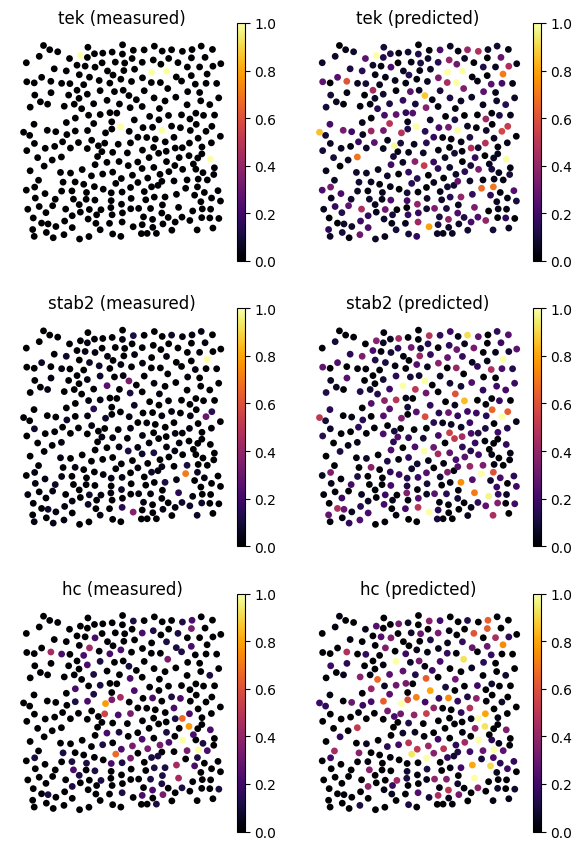

In [17]:
# The comparison between original measurements on predicted ones is easily done with tangram

tg.plot_genes_sc(
    genes, adata_measured=adata_st[adata_st.obs.FOV==0], adata_predicted=ad_ge[ad_ge.obs.FOV==0], perc=0.02, spot_size=50
)

#### Plotting genes that were not part of the training data

We can also inspect genes there were part of the training genes but not detected in the spatial data

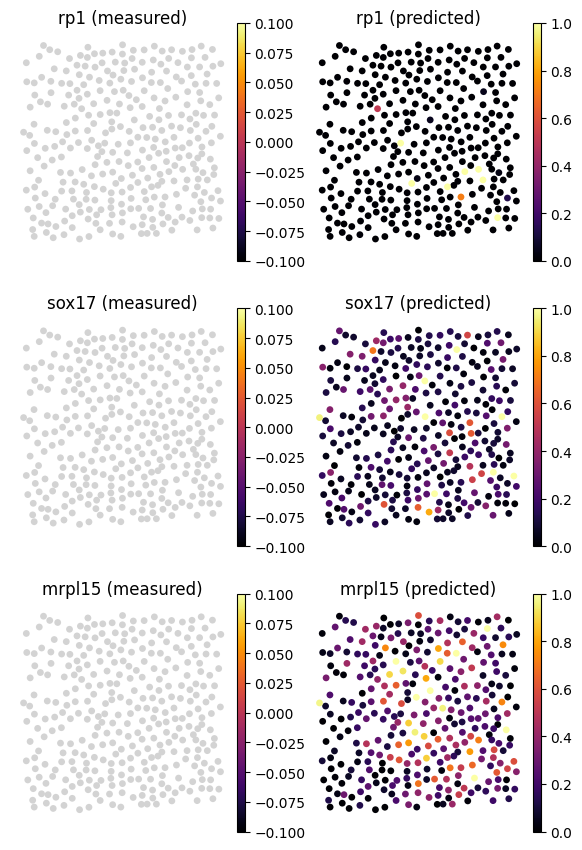

In [18]:
genes=['rp1', 'sox17', 'mrpl15']
tg.plot_genes_sc(
    genes, adata_measured=adata_st[adata_st.obs.FOV==0], adata_predicted=ad_ge[ad_ge.obs.FOV==0], perc=0.02, spot_size=50
)

## Validation on expression level

An additional step for the task of imputation might be to validate if the cell-type specific expression levels can still be recovered with in the predicted counts. For this purpose, one selects a few highly expressed markers per cluster and compares the normalized expression levels. For convenience, we use the markers as described by Lu et al.{cite}`lu_spatial_2021`, but one could also run a simple differential expression test between clusters to identify marker genes. 

In [19]:
control_markers = [
    'tfrc', 'e2f2', 'abcb4', 'myh10', 'podxl', 'cd34', 'sdc3', 'pzp',
    'hc', 'mrvi1', 'gnaz', 'vwf', 'kdr', 'stab2', 'flt4', 'col4a1'
]

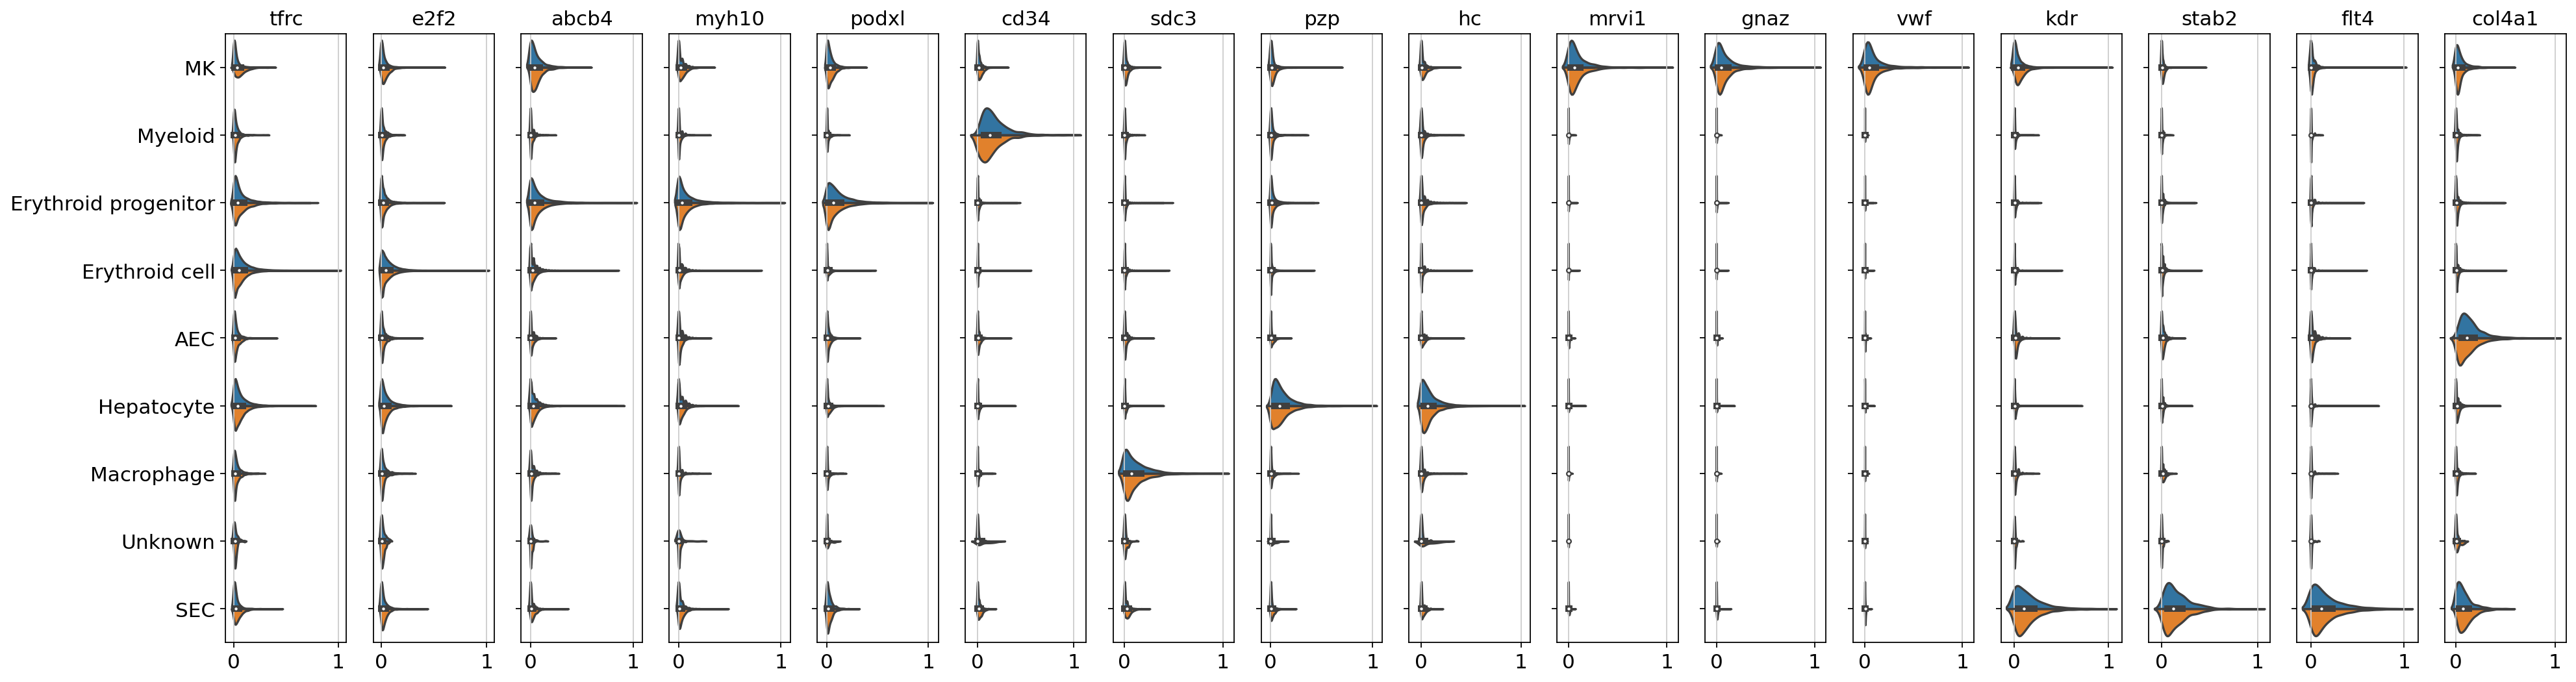

In [22]:
from sklearn.preprocessing import MinMaxScaler

#sc.set_figure_params(scanpy=True, fontsize=22)
fig, ax = plt.subplots(1,len(control_markers), figsize=(25,6.8), sharey=True)
for i, marker in enumerate(control_markers):
    # Retrieving measured counts
    measured = sc.get.obs_df(adata_st, [marker, 'cell_type'])
    # Calculating measured expression levels
    measured['expression_level']=MinMaxScaler().fit(measured[[marker]]).transform(measured[[marker]])
    
    # Retrieving measured counts
    predicted = sc.get.obs_df(ad_ge, [marker, 'cell_type'])
    # Calculating predicted expression levels
    predicted['expression_level']=MinMaxScaler().fit(predicted[[marker]]).transform(predicted[[marker]])

    sns.violinplot(
        data=pd.concat([measured, predicted], keys=['measured', 'predicted'], names=['sample']).reset_index(), 
        y='cell_type', x='expression_level', hue="sample", split=True, ax=ax[i],
    )
    ax[i].set_title(marker)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].get_legend().remove()
plt.tight_layout()
plt.show()

As we can inspect, the cluster-wise expression levels of marker genes can still be recovered.

# Conclusions
# New directions
# Key takeaways
# References

```{bibliography}
:filter: docname in docnames
:labelprefix: spatial
```

# Contributors
## Authors
* Leon Hetzel
* Anna Schaar

## Reviewers
